In [1]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

In [2]:
from transformers import AutoTokenizer,AutoModelForCausalLM, AutoConfig
input_text = "My dog really wanted to"
from transformers import pipeline
generator = pipeline("text-generation", model="openai-community/gpt2")
generator(input_text, max_length=20, num_return_sequences=5)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "My dog really wanted to do this\n\nBut he couldn't. He was so depressed.\n"},
 {'generated_text': 'My dog really wanted to call him a cheetah. [The dog] told her that che'},
 {'generated_text': 'My dog really wanted to be with me and she had a good time with me," Kipnis'},
 {'generated_text': "My dog really wanted to keep him, because I thought he'd really love me, or just give"},
 {'generated_text': 'My dog really wanted to walk me to my room and I thought about him every day, the same'}]

In [3]:
!pip install accelerate -U

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [4]:
from transformers import TextDataset,DataCollatorForLanguageModeling

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128) 
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

In [5]:
from transformers import AutoTokenizer,AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_dataset,test_dataset,data_collator = load_dataset('dataset/train_input.txt','dataset/test_input.txt', tokenizer)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 40, # Number of update steps between two evaluations.
    save_steps=80, # after # steps model is saved 
    warmup_steps=50,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
/home/tnguyent/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
Detected kernel version 5.3.18, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or hi

In [6]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('openai-community/gpt2')
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [7]:
## IMPORTS

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

In [8]:
C = 32 # channels
head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# Here we want the wei to be data dependent - ie gather info from the past but in a data dependant way

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16) # each token here (totally B*T) produce a key and query in parallel and independently
q = query(x) # (B, T, 16)
v = value(x)

wei =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T). #
wei = F.softmax(wei, dim=-1) # exponentiate and normalize giving a nice distibution that sums to 1 and
                             # now it tells us that in a data dependent manner how much of info to aggregate from

out = wei @ v # aggregate the attention scores and value vector.


In [10]:
print(out[0])

tensor([[ 0.0618, -0.0091, -0.3488,  0.3208,  0.2971, -0.1573, -0.0561,  0.1068,
          0.0368,  0.0139, -0.0017,  0.3110,  0.1404, -0.0158,  0.1853,  0.4290],
        [ 0.1578, -0.0971, -0.4256,  0.3538,  0.3621, -0.2392, -0.0536,  0.1759,
          0.1115,  0.0282, -0.0649,  0.3641,  0.1928,  0.0261,  0.2162,  0.3758],
        [ 0.1293,  0.0759, -0.2946,  0.2292,  0.2215, -0.0710, -0.0107,  0.1616,
         -0.0930, -0.0877,  0.0567,  0.1899,  0.0311, -0.0894,  0.0309,  0.5471],
        [ 0.1247,  0.1400, -0.2436,  0.1819,  0.1976,  0.0338, -0.0028,  0.1124,
         -0.1477, -0.0748,  0.0650,  0.1392, -0.0314, -0.0989,  0.0613,  0.5433],
        [ 0.0667,  0.1845, -0.2135,  0.2813,  0.2064,  0.0873,  0.0084,  0.2055,
         -0.1130, -0.1466,  0.0459,  0.1923, -0.0275, -0.1107,  0.0065,  0.4674],
        [ 0.1924,  0.1693, -0.1568,  0.2284,  0.1620,  0.0737,  0.0443,  0.2519,
         -0.1912, -0.1979,  0.0832,  0.0713, -0.0826, -0.0848, -0.1047,  0.6089],
        [ 0.1184,  0.0

In [11]:
!pip install bertviz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [12]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM

from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = 'openai-community/gpt2'
input_text = "No, I am your father"  
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

In [13]:
vocab_size = 65
n_embd = 64

token_embedding_table = nn.Embedding(vocab_size, n_embd)
block_size = 32 # what is the maximum context length for predictions?
position_embedding_table = nn.Embedding(block_size, n_embd)

In [14]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x = token_embedding_table(x)
print(x[0])

tensor([-1.7835e-01,  7.8658e-01, -2.9929e-01, -2.3873e-02, -5.0914e-01,
         2.4441e-01, -8.2169e-02,  3.6466e-01, -1.8270e+00, -1.2369e+00,
        -7.3462e-01,  4.6940e-01, -3.5877e-01,  2.5710e-01,  2.0993e+00,
        -6.5342e-01,  1.2830e+00, -3.9340e-01, -2.4689e-01, -2.3424e-01,
        -9.2546e-01,  4.4579e-01,  6.5937e-01,  3.4739e-01, -2.0431e+00,
         5.1571e-01,  7.1762e-01, -7.0401e-01,  3.1290e-02, -8.9843e-01,
        -1.2214e+00,  1.2941e-01, -1.3824e+00,  4.5792e-03, -1.8496e+00,
         3.1221e-01, -5.8248e-02,  1.1976e+00,  3.8808e-01,  7.5234e-04,
         5.7398e-02,  1.1069e+00, -1.1624e-01,  1.1645e-01,  3.2158e-01,
         3.8281e-01,  6.7035e-01,  1.3830e-01, -6.9637e-01, -2.0735e-01,
         1.3373e+00, -1.5333e+00, -2.8898e-01,  1.1616e+00, -1.0458e+00,
        -1.3420e+00,  1.2078e+00, -8.5998e-02,  1.0968e+00,  6.9780e-01,
         5.5507e-01,  4.4563e-01, -8.4776e-01, -1.5894e+00],
       grad_fn=<SelectBackward0>)


In [15]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x= position_embedding_table(x) + token_embedding_table(x)
print(x[0])

tensor([-0.5348,  1.0764, -1.0312,  1.7759, -2.5882,  0.0404, -1.5108, -1.1320,
        -3.0570, -1.8606, -0.7382, -1.2091, -1.0702,  1.1321,  0.9480, -0.2523,
         2.6011, -2.4835, -0.1853, -0.5392, -0.6317,  1.8903,  0.4332, -0.5731,
        -0.0286,  1.3354, -0.6846,  1.2807, -0.2313, -0.5876, -0.3106, -0.3120,
        -1.4616, -0.4213, -2.6455, -0.1974, -1.1531,  2.6413,  1.4639, -0.4758,
         1.0479,  1.2803,  0.5265,  0.6791,  0.4458, -1.3022,  0.1740, -0.2600,
        -1.1940, -0.8797,  2.3601, -2.3947, -0.8889, -1.2826, -1.9416, -0.9030,
         0.4287,  0.0597,  2.7288,  0.8362, -0.0783, -0.4978, -1.6223, -1.4962],
       grad_fn=<SelectBackward0>)


In [16]:
from torch.nn import functional as F
logits = torch.tensor([0.5, 0.1, 0.3])
targets = torch.tensor([1.0, 0.0, 0.0])
loss = F.cross_entropy(logits, targets)
print(loss)

tensor(0.9119)


In [17]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(2.4891)


In [18]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

In [19]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [20]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [21]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

In [22]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [23]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [24]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

Step: 0, Train Loss: 4.094468593597412, Val Loss: 4.092559814453125
Step: 10, Train Loss: 3.3876137733459473, Val Loss: 3.415436029434204
Step: 20, Train Loss: 3.2497808933258057, Val Loss: 3.2953882217407227
Step: 30, Train Loss: 3.126052141189575, Val Loss: 3.1798043251037598
Step: 40, Train Loss: 3.0196192264556885, Val Loss: 3.048623561859131
Step: 50, Train Loss: 2.925534725189209, Val Loss: 2.941763401031494
Step: 60, Train Loss: 2.8433682918548584, Val Loss: 2.8496041297912598
Step: 70, Train Loss: 2.780139207839966, Val Loss: 2.7929749488830566
Step: 80, Train Loss: 2.718958854675293, Val Loss: 2.7352917194366455
Step: 90, Train Loss: 2.686169147491455, Val Loss: 2.677408456802368
Step: 100, Train Loss: 2.6529603004455566, Val Loss: 2.6579787731170654
Step: 110, Train Loss: 2.6223952770233154, Val Loss: 2.6180925369262695
Step: 120, Train Loss: 2.605808734893799, Val Loss: 2.5961344242095947
Step: 130, Train Loss: 2.5905394554138184, Val Loss: 2.5866754055023193
Step: 140, Trai

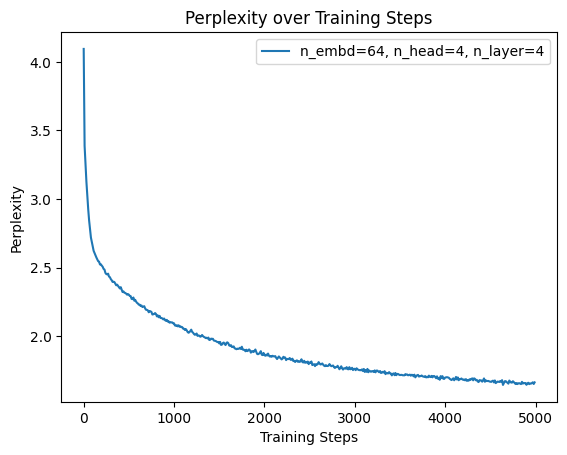

Step: 0, Train Loss: 4.172012805938721, Val Loss: 4.174652576446533
Step: 10, Train Loss: 3.4045569896698, Val Loss: 3.437119483947754
Step: 20, Train Loss: 3.225302219390869, Val Loss: 3.2651376724243164
Step: 30, Train Loss: 3.0958411693573, Val Loss: 3.1236846446990967
Step: 40, Train Loss: 2.9855661392211914, Val Loss: 2.9988417625427246
Step: 50, Train Loss: 2.8883626461029053, Val Loss: 2.9178216457366943
Step: 60, Train Loss: 2.823512077331543, Val Loss: 2.857663869857788
Step: 70, Train Loss: 2.7628214359283447, Val Loss: 2.7943880558013916
Step: 80, Train Loss: 2.732734441757202, Val Loss: 2.751629114151001
Step: 90, Train Loss: 2.6920905113220215, Val Loss: 2.6991260051727295
Step: 100, Train Loss: 2.6488089561462402, Val Loss: 2.6591904163360596
Step: 110, Train Loss: 2.6442954540252686, Val Loss: 2.6444790363311768
Step: 120, Train Loss: 2.6173171997070312, Val Loss: 2.619143009185791
Step: 130, Train Loss: 2.5939199924468994, Val Loss: 2.587609052658081
Step: 140, Train Lo

In [ ]:
import matplotlib.pyplot as plt

# Training loop
def train_model(n_embd, n_head, n_layer):
    global model
    model = LanguageModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for step in range(max_iters):
        X, Y = get_batch('train')
        logits, loss = model(X, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % eval_interval == 0:
            losses = estimate_loss()
            train_loss = losses['train']
            val_loss = losses['val']
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f'Step: {step}, Train Loss: {train_loss}, Val Loss: {val_loss}')

    plt.plot(range(0, max_iters, eval_interval), train_losses, label=f'n_embd={n_embd}, n_head={n_head}, n_layer={n_layer}')
    plt.xlabel('Training Steps')
    plt.ylabel('Perplexity')
    plt.title('Perplexity over Training Steps')
    plt.legend()
    plt.show()

# Run training loop with different hyperparameters
train_model(64, 4, 4)
train_model(128, 4, 4)
train_model(64, 8, 4)
train_model(64, 4, 8)


# Note
I was not able to run the entire of code because the limit time and number of cpu I can select. I provided my code as required above, and some prelim results